## 본 텀 프로젝트는 전체적인 흐름 파악이 매우 중요합니다.
## 따라서 Overview와 스켈레톤 코드를 처음부터 끝까지 살펴보고 구현을 시작하시길 바랍니다.
### 
### (스켈레톤 코드를 Edit My Copy 버튼을 통해 사용하세요)
### 함수를 실행하는 부분은 스켈레톤 코드로 제공됩니다.
### 함수 선언부에 비어있는 Empty Module을 overview 설명과, 스켈레톤 코드의 설명을 참고하여 채우시면 됩니다.

## GPU 활성화!
* **K-Means GPU 사용을 위해서 Accelerator를 GPU로 설정해야 합니다.**
* **아래 그림을 참고하여 노트북 실행 전 우측 Notebook options에서 GPU P100으로 설정해주세요.**

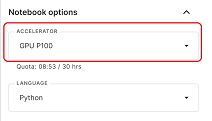

---------------------------
## **0. 필요 라이브러리 설치 및 불러오기**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#K-Means clustering,GPU 실행을 위한 라이브러리 설치

!pip install faiss-gpu

In [ ]:
#구현에 필요한 라이브러리 import

import cv2

import scipy.cluster.vq as vq
import faiss
from sklearn import svm
from tqdm import tqdm

In [ ]:
#랜덤시드 고정

import random
import os
seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
# numpy로 경로에 있는 csv 파일을 읽어들이는 함수
def load_csv(path):
    return np.loadtxt(path, delimiter=',')


---------------------------
# **1. 데이터셋 불러오기**
## **[Empty Module #1] load_dataset**
* **csv 파일로 구성된 2D 이미지 데이터를 numpy 형태로 가져오기**

In [ ]:
# -------------------------------------
# [Empty Module #1] 학습데이터, 평가데이터 불러오기 
# -------------------------------------


# -------------------------------------
# load_dataset(path, split):
# -------------------------------------
# 목적: 학습데이터 불러오기
# 입력인자: path - 데이터 경로, split - train인지 test인지 여부
# 출력인자: split="TRAIN"일 경우 : train_images - 학습데이터(2D img), 학습라벨(ex. Faces, airplanes,,,,)
#          split="TEST"일 경우 : test_images - 평가데이터(2D img)
# -------------------------------------



def load_dataset(path, split):
    
    if split == 'TRAIN':
        train_images = []
        train_labels = []
        classes = os.listdir(path)
        
        for cls_ in tqdm(classes):
            cls_images = os.listdir(os.path.join(path, cls_))# 각 class 폴더에 접근하여 이미지 접근
            
            for cls_img in cls_images:
                # ------------------------------------------------------------
                # 구현 가이드라인
                # ------------------------------------------------------------
                # 경로의 이미지를 읽어와서 numpy 형태로 변경 하는 코드를 작성하라
                # 1D 데이터를 2D 형태인 RGB 데이터(256,256,3)로 변환하고
                # uint64로 제공된 데이터를 astype를 사용하여 uint8로 변경
                # ------------------------------------------------------------
                # 구현 가이드라인을 참고하여 아래쪽에 코드를 추가하라
                path_img = os.path.join(path, cls_, cls_img)
                img = pd.read_csv(path_img).values
                img = img.reshape(256, 256, 3)
                img = img.astype(np.uint8)
                train_images.append(img)
                train_labels.append(cls_)
                
                # ------------------------------------------------------------
        
        return np.array(train_images), np.array(train_labels) # (3060, 256, 256, 3), (3060)
    
    
    elif split == 'TEST':
        img_name = sorted(os.listdir(path))
        test_images = []
        for img in tqdm(img_name):
            # ------------------------------------------------------------
            # 구현 가이드라인
            # ------------------------------------------------------------
            # 경로의 이미지를 읽어와서 numpy 형태로 변경 후
            # 1D 데이터를 2D 형태인 RGB 데이터(256,256,3)로 변환하고
            # uint64로 제공된 데이터를 astype를 사용하여 uint8로 변경
            # ------------------------------------------------------------
            # 구현 가이드라인을 참고하여 아래쪽에 코드를 추가하라
            path_img = os.path.join(path, img)
            img = pd.read_csv(path_img).values
            img = img.reshape(256, 256, 3)
            img = img.astype(np.uint8)
            test_images.append(img)
            # ------------------------------------------------------------
            
        return np.array(test_images) # (1712, 256, 256, 3)

In [ ]:
#경로 설정

train_path = os.path.join('/kaggle/input/2023-ml-project2/train_csv_v2')
test_path = os.path.join('/kaggle/input/2023-ml-project2/test_csv_v2')
label_path = os.path.join('/kaggle/input/2023-ml-project2/Label2Names.csv')

In [ ]:
#train, test에 대해 load_dataset 함수 실행

train_images, train_labels_ = load_dataset(train_path, 'TRAIN')
test_images = load_dataset(test_path, 'TEST')

## **label_to_index**
* **클래스 명을 범주형 라벨로 변환하는 함수**
 * **(예) "crocodile_head" -> 30**
 * **"BACKGRAOUND_Google"은 Label2Names.csv 안에 없으며, 102로 매핑해서 사용 할 예정**

In [ ]:
def label_to_index(train_labels_, label_path):
    
    label_name = pd.read_csv(label_path, header = None) 
    label_map = dict()

    for i in range(len(label_name)):
        label_map[label_name[1][i]] = i+1
        
    label_map['BACKGROUND_Google'] = 102

    train_labels = [label_map[train_labels_[i]] for i in range(len(train_labels_))]
    
    return train_labels

In [ ]:
#분류기 학습에 사용할 label 정보 미리 추출하기

train_labels = label_to_index(train_labels_, label_path)

__________________________________________

##  **+ numpy 형태로 불러온 Caltech 101 데이터셋 그림으로 살펴보기**
**(index를 바꿔가면서 데이터셋의 구성을 살펴보세요)**

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure()
rows = 1
cols = 3

img1 = train_images[7]
img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)

img2 = train_images[77]
img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

img3 = train_images[777]
img3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img1)
ax1.set_title(train_labels_[7])
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(img2)
ax2.set_title(train_labels_[77])
ax2.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 3)
ax2.imshow(img3)
ax2.set_title(train_labels_[777])
ax2.axis("off")
 
plt.show()

---------------------------
# **2. 특징점, 기술자 추출하기**
## **[Empty Module #2] extract_descriptor**
* **아래 모듈 'else' 블럭의 일반 SIFT 코드를 참고해서, 'if isDense is True' 블럭 채우기**
* **SIFT의 detect 함수와 compute 함수를 활용한다.**
* **SIFT의 detect 함수는 특징점 위치를 추출하는 함수이고, compute 함수는 특징점 위치에서 주변 정보를 기술하는 기술자를 추출하는 함수이다.**
* **(힌트 : DenseSIFT의 경우는 이미지 내 모든 영역에 Dense하게 특징점이 존재한다고 가정하는 방법론이므로 step_size = 8 로 설정하여 이미지 내에 특징점을 먼저 설정한 후 sift compute를 진행하기)**
* **(라이브러리 라이선스 이슈 때문에 cv2.xfeatures2d.SIFT_create() 말고 cv2.SIFT_create() 사용할 것)**
* **[documentation](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html) 참고**

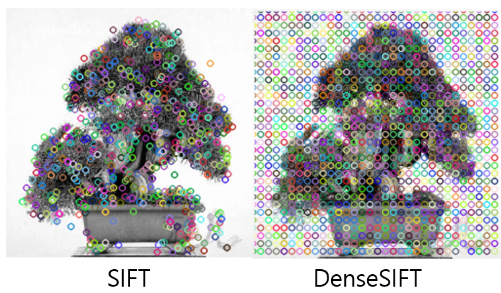

In [ ]:
isDense = True 
# True : DenseSIFT,  False : 일반 SIFT

In [ ]:
# -------------------------------------
# [Empty Module #2] 특징점 추출하기
# -------------------------------------


# -------------------------------------
# extract_descriptor(img, isDense = False):
# -------------------------------------
# 목적: 이미지 내에서 특징점(feature point)을 추출(detect)하고 기술(describe)하기
# 입력인자: img - numpy형태 이미지, isDense - DenseSIFT인지 아닌지 여부
# 출력인자: des - 이미지의 특징점에서 기술된 기술자(descriptor)
# -------------------------------------


def extract_descriptor(img, isDense = False):
    
    sift = cv2.SIFT_create()
    
    if isDense is True: # DenseSIFT 추출
        
        step_size = 8
        # ------------------------------------------------------------
        # 구현 가이드라인
        # ------------------------------------------------------------
        # cv2.KeyPoint 함수를 사용해 step_size=8 만큼의 dense한 특징점 설정
           # -(kp는 cv2.Keypoint 객체들을 담는 list로 세팅)
           # -(256x256의 이미지 사이즈에서 step_size=8일 경우 32x32=1024개의 특징점 생성. 따라서 len(kp)=1024)
        # cv2.cvtColor 함수를 사용해 이미지를 gray 형태로 변형 (SIFT 추출을 위해)
        # 미리 설정한 특징점으로 부터 SIFT 기술자(descriptor) 추출
        # ------------------------------------------------------------
        # 구현 가이드라인을 참고하여 아래쪽에 코드를 추가하라
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
                                                for x in range(0, gray.shape[1], step_size)]
        _, des = sift.compute(gray, kp)
        # ------------------------------------------------------------
    
    else: # 일반 SIFT 추출
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, des = sift.detectAndCompute(gray, None)
        
    return des

In [ ]:
# Codebook 생성을 위해 학습 이미지 전체에서 기술자 추출하기

train_descriptors = [extract_descriptor(train_img, isDense = isDense) for train_img in tqdm(train_images)]
    
train_descriptors = np.array(train_descriptors)

---------------------------
# **3. Codebook 생성**
* **추출한 SIFT (or DenseSIFT)의 기술자(descriptor)를 사용해서 Codebook 생성**
* **위에서 구한 train_descriptors는 모든 학습 이미지에서 특징점(visual word)를 구한 것이다.**
* **수 많은 특징점(visual word) 중 K-Means clustering을 통해 대표가 되는 특징점(codeword)들을 선정하고 이들을 묶어서 codebook을 만들어야 한다.**
* **특징점(codeword)의 수는 baseline에서 모두 200으로 세팅**

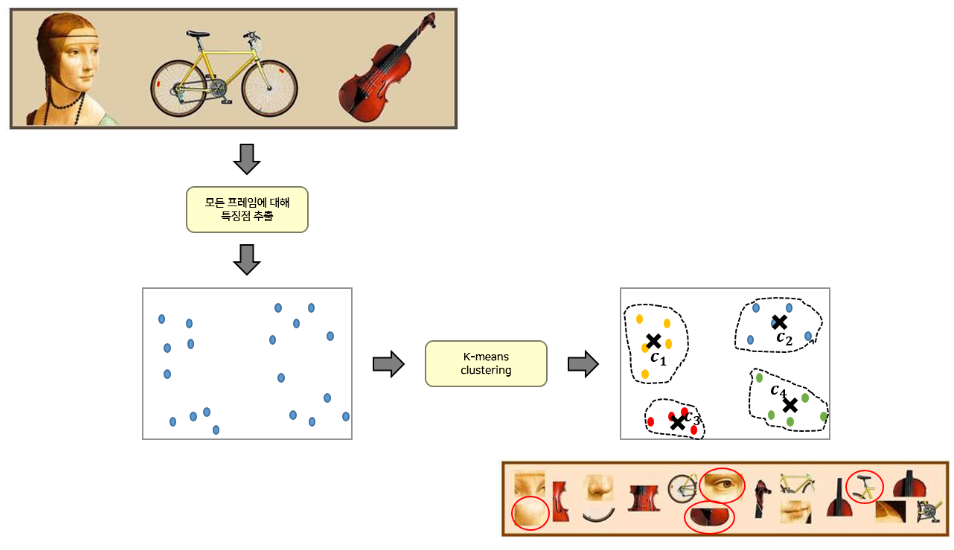

In [ ]:
n_codeword = 200

In [ ]:
def build_codebook_GPU(X,voc_size):
    
    feature=np.array(X).reshape(-1,128).astype('float32') # reshape(-1,128) : 128차원의 SIFT 기술자를 1차원으로 변환
    d=feature.shape[1] # d=128
    k=voc_size # k=200
    clus = faiss.Clustering(d, k) # faiss 라이브러리의 Clustering 함수를 사용해 k-means clustering 수행
    clus.niter = 300 # k-means clustering의 최대 반복 횟수
    clus.seed = 8 # k-means clustering의 seed 값
    clus.max_points_per_centroid = 10000000 # k-means clustering의 최대 데이터 수
    ngpu=1
    res = [faiss.StandardGpuResources() for i in tqdm(range(ngpu))] 
    flat_config = [] 
    for i in tqdm(range(ngpu)):
        cfg = faiss.GpuIndexFlatConfig() 
        cfg.useFloat16 = False
        cfg.device = i
        flat_config.append(cfg)
    if ngpu == 1:
        index = faiss.GpuIndexFlatL2(res[0], d, flat_config[0]) # faiss 라이브러리의 GpuIndexFlatL2 함수를 사용해 GPU를 사용한 k-means clustering 수행
    clus.train(feature, index)
    centroids = faiss.vector_float_to_array(clus.centroids) # 
    centroids=centroids.reshape(k, d) 
    
    return centroids

In [ ]:
#codeword들이 모인 codebook 구하기
codebook = build_codebook_GPU(train_descriptors, n_codeword)

---------------------------
# **4. BOVW, VLAD vector 생성**
## **[Empty Module #3] BOVW**
* **생성해둔 codebook(kmeans clustrer center) 와 특징점(visual word)을 비교하여 histogram을 구하는 작업 진행**
* **scipy.cluster.vq를 사용해 각 특징점(visual word)과 유사한 codebook의 Index를 반환 받아 사용**
 * ([메뉴얼](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html) 참고)
* **vq를 이용해 얻은 Index를 np.histogram 을 사용해 histogram을 구한다**
 * **np.histogram 사용 시 bin의 range를 (0, n_codeword+1)로 설정**
 * ([메뉴얼](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html) 참고)

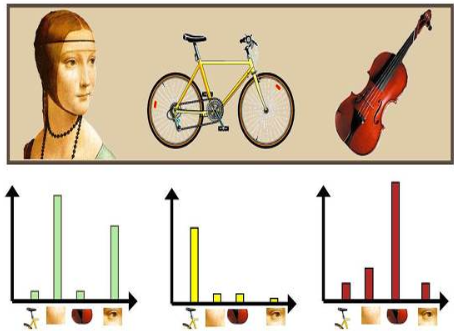

## **[Empty Module #4] VLAD**
* **BOVW에서는 각 특징점(visual word)와 유사한 codebook의 Index를 사용했다면,**
* **VLAD 에서는 각 특징점(visual word)을 codebook내 대표 특징점(codeword) 중 가장 유사한 것과 벡터 차이를 계산한 후, 동일한 대표 특징점(codeword)에 할당된 특징점(visual word)의 벡터 차이 값을 모두 더해주는 방식으로 VLAD feature를 기술**

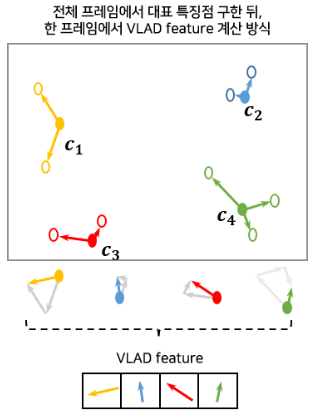

In [ ]:
#BOVW 기술자와 VLAD 기술자 중 어떤 것을 사용할지 선정

args_desc = "BOVW" # or "VLAD"

In [ ]:
# -------------------------------------
# [Empty Module #3] BOVW 알고리즘
# -------------------------------------


# -------------------------------------
# BOVW(descriptor, codebook): 
# -------------------------------------
# 목적: Histogram (즉, 빈도수)를 계산하기 위한 함수 (BOVW 기술자를 계산하기 위한 함수)
# 입력인자: descriptor - 한 이미지에서 추출된 기술자(descriptor)들의 모음 ([1024,128] --> DenseSIFT의 경우 1024)
#          codebook - 학습데이터 전체를 대표하는 codeword들의 모음 ([200,128])
# 출력인자: hist - feature의 codebook 빈도수(즉 histogram)을 flatten한 Matrix
# -------------------------------------


def BOVW(descriptor, codebook):
    
    # ------------------------------------------------------------
    # 구현 가이드라인
    # ------------------------------------------------------------
    # 1) scipy.cluster.vq 를 사용해 각 특징점(visual word)과 가장 유사한 codebook의 Index를 반환
    # 2) 구한 Index들 histogram을  np.histogram 을 사용해 histogram을 구한다
    # 2-Tip) np.histogram 사용시 bin의 range를 (0, n_codeword+1)로 설정
    # ------------------------------------------------------------
    # 구현 가이드라인을 참고하여 아래쪽에 코드를 추가하라
    descriptor = descriptor.tolist()
    index = vq.vq(descriptor, codebook) # vq.vq 함수를 사용해 각 특징점(visual word)과 가장 유사한 codebook의 Index를 반환
    hist, _ = np.histogram(index, bins=range(0, codebook.shpae[0]+1), normed=True) # np.histogram 을 사용해 histogram을 구한다
    # ------------------------------------------------------------
    
    return hist


In [ ]:
# -------------------------------------
# [Empty Module #4] VLAD 알고리즘
# -------------------------------------


# -------------------------------------
# VLAD(descriptor, codebook): 
# -------------------------------------
# 목적: VLAD 기술자를 계산하기 위한 함수
# 입력인자: descriptor - 한 이미지에서 추출된 기술자(descriptor)들의 모음 ([1024,128] --> DenseSIFT의 경우 1024)
#          codebook - 학습데이터 전체를 대표하는 codeword들의 모음 ([200,128])
# 출력인자: V - 계산한 VLAD 기술자
# -------------------------------------

def VLAD(descriptor, codebook):

    #VLAD 기술자를 담기 위한 변수
    V = np.zeros([codebook.shape[0], descriptor.shape[1]]) 
    
    # ------------------------------------------------------------
    # 구현 가이드라인
    # ------------------------------------------------------------
    # 1) scipy.cluster.vq 를 사용해 각 특징점(visual word)과 가장 유사한 codebook의 Index를 반환
    # 2) 동일한 대표 특징점(codeword)으로 할당된 특징점(visual word)들의 벡터 합 계산해 V[i]에 저장
    # (한 이미지에서 얻게 되는 VLAD 기술자인 V의 shape은 (n_codeword,128))
    # ------------------------------------------------------------
    # 구현 가이드라인을 참고하여 아래쪽에 코드를 추가하라
    descriptor = descriptor.tolist()
    index = vq.vq(descriptor, codebook)
    for i in range(len(index)): # 동일한 대표 특징점(codeword)으로 할당된 특징점(visual word)들의 벡터 합 계산해 V[i]에 저장
        V[index[i]] += descriptor[i] - codebook[index[i]] # VLAD 기술자를 담기 위한 변수 V에 저장
    # ------------------------------------------------------------
    
    # 후처리 과정
    V = V.flatten()

    V = np.sign(V)*np.sqrt(np.abs(V))
    if np.sqrt(np.dot(V,V))!=0:
        V = V/np.sqrt(np.dot(V,V))
        
    return V

In [6]:
import numpy as np
a = np.array([[1,2],[4,5]])
b = np.array([[1,2,3],[4,5,6]])
print(a.shape, b.shape)
print(a)
print(b)

(2, 2) (2, 3)
[[1 2]
 [4 5]]
[[1 2 3]
 [4 5 6]]


# **+<Spatial Pyramid Matching 기법>**
* **Spatial Pyramid Matching 방법에서는 여기에 추가적으로 이미지를 점진적으로 세분(level 1에서는 2x2로 분할, level 2에서는 4x4로 분할, ...)해 가면서 각각의 분할 영역마다 별도로 히스토그램을 구한 후,**
* **이들 히스토그램들을 전부 모아서 일종의 피라미드(pyramid)를 형성**
* **(level=0일 경우 Spatial Pyramid Matching을 적용하지 않고, 영상 전체에 대해서 한번만 기술자를 추출한다.)**


## **[Empty Module #5] cut_image**
* **Spatial Pyramid Matching 기법 적용을 위해 입력 이미지를 자르는(cut) 함수**
* **입력 이미지를 입력 level에 맞게 잘라서 새로운 리스트(cutted_img)에 담은 뒤 return 하는 역할**
* **만약 level=1일 경우 함수에서 반환하는 리스트(cutted_img)의 길이는 4가 된다.**

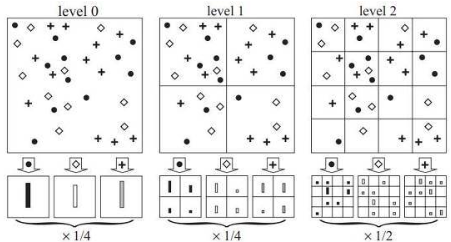

In [ ]:
#Spatial Pyramid Matching 의 사용 여부 결정하기
#[0]으로 세팅할 경우 전통적인 기법들 처럼 level 0만 사용하게 되고,
#[0,1,2]로 세팅할 경우 level 0,1,2 모두를 더해 예측에 사용

pyramid_levels = [0] #or [0,1], [0,1,2] 로 세팅 가능

In [ ]:
# -------------------------------------
# [Empty Module #5] cut_image 함수
# -------------------------------------


# -------------------------------------
# cut_image(img, level): 
# -------------------------------------
# 목적: Spatial Pyramid Matching을 위해 입력 이미지를 level에 맞게 자르는 함수
# 입력인자: img - 자르고자 하는 입력 이미지
#          level - 자를 level 선정 (overview 그림 참고)
# 출력인자: cutted_img - 자른 이미지를 담은 리스트
# -------------------------------------

def cut_image(img, level):

    if level == 0:  # level이 0이기 때문에 Spatial Pyramid Matching을 적용하지 않는다. 따라서 입력 img 그대로 return 
        return [img]
    
    else:    # Spatial Pyramid Matching을 적용하는 경우
        h_end, w_end, _ = img.shape #입력 이미지의 높이와 너비
        cutted_img = [] #자른 이미지를 담을 리스트

        w_start = 0
        h_start = 0

        w = w_end // (2**level)
        h = h_end // (2**level)
        
        # ------------------------------------------------------------
        # 구현 가이드라인
        # ------------------------------------------------------------
        # 입력 level에 맞게 입력 이미지를 잘라서 cutted_img에 append 해주기
        # 반복문 돌때마다 w_start와 h_start 를 새롭게 갱신해주기
        # ------------------------------------------------------------
        # 구현 가이드라인을 참고하여 아래쪽에 코드를 추가하라
    
        for i in range((4 ** level)):#레벨 1에서는 원본이미지를 4등분(2x2), 레벨2에서는 원본이미지에서 16등분(4x4)함
            cutted_img.append(img[h_start:h_start+h, w_start:w_start+w, :]) #입력 level에 맞게 입력 이미지를 잘라서 cutted_img에 append 해주기
            w_start += w
            if w_start == w_end: # w_end에 도달하면 w_start를 0으로 초기화하고 h_start를 h만큼 증가시켜준다
                w_start = 0
                h_start += h
            
        # ------------------------------------------------------------    

        return cutted_img

In [ ]:
# 학습, 테스트 이미지를 세팅한 pyramid_levels 에 대해 자르고(cut),
# 자른 이미지에 대해 각각 BOVW 또는 VLAD 구하기

# train_images
train_vec = []

for level in pyramid_levels:
    pyramid_histogram = []
    for train_img in tqdm(train_images):
        
        pyramid_hist = []
        cut_imgs = cut_image(train_img, level)
        
        for cut_img in cut_imgs:
            desc_cut = extract_descriptor(cut_img, isDense = isDense)
            if desc_cut is not None:
                if args_desc == "BOVW":
                    hist_cut = BOVW(desc_cut, codebook)
                elif args_desc == "VLAD":
                    hist_cut = VLAD(desc_cut, codebook)

                pyramid_hist.extend(hist_cut)
                
        if len(pyramid_hist) !=0:  
            pyramid_histogram.append(np.array(pyramid_hist))
        else:
            # 일반 SIFT (Dense X)에서 SIFT 검출이 안된 이미지의 경우 에러 방지를 위해 임의로 0 채우기
            pyramid_histogram.append(np.zeros(200).astype('int64'))
        
    train_vec.append(np.array(pyramid_histogram))

# test_images
test_vec = []

for level in pyramid_levels:
    pyramid_histogram = []
    for test_img in tqdm(test_images):
        
        pyramid_hist = []
        cut_imgs = cut_image(test_img, level)
        
        for cut_img in cut_imgs:
            desc_cut = extract_descriptor(cut_img, isDense = isDense)
            if desc_cut is not None:
                if args_desc == "BOVW":
                    hist_cut = BOVW(desc_cut, codebook)
                elif args_desc == "VLAD":
                    hist_cut = VLAD(desc_cut, codebook)                

                pyramid_hist.extend(hist_cut)
        
        if len(pyramid_hist) !=0:
            pyramid_histogram.append(np.array(pyramid_hist))
        else:
            # 일반 SIFT (Dense X)에서 SIFT 검출이 안된 이미지의 경우 에러 방지를 위해 임의로 0 채우기
            pyramid_histogram.append(np.zeros(200).astype('int64'))
    
    test_vec.append(np.array(pyramid_histogram))

---------------------------
# **5. SVM : 분류기 학습**
## **[Empty Module #6] SVM**
* **앞서 구한 정보를 사용하여 SVM 분류기 학습**
* **베이스라인 파라미터는 default 유지. <svm.SVC()>**

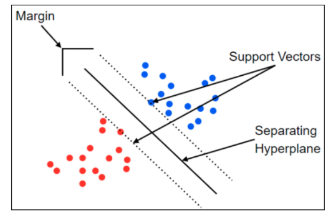

In [ ]:
train_vectors = []

for vec in train_vec:
    if train_vectors == []:
        train_vectors = vec
    else:
        train_vectors = np.hstack((train_vectors, vec)) # hstack은 수평으로 쌓는다는 뜻
        
        
test_vectors = []

for vec in test_vec:
    if test_vectors == []:
        test_vectors = vec
    else:
        test_vectors = np.hstack((test_vectors, vec))

In [ ]:
# -------------------------------------
# [Empty Module #6] SVM 분류기 학습
# -------------------------------------


def SVM(train_vectors, train_labels, test_vectors):
        
    # ------------------------------------------------------------
    # 구현 가이드라인
    # ------------------------------------------------------------
    # 모든 baseline성능은 clf = svm.SVC() 로 예측한 성능임
    # 분류기로 예측한 최종 예측값을 반환하는 함수
    # ------------------------------------------------------------
    # 구현 가이드라인을 참고하여 아래쪽에 코드를 추가하라
    
    clf = svm.SVC() # model
    clf.fit(train_vectors, train_labels) # model training
    predict = clf.predict(test_vectors) # predict testset

    # ------------------------------------------------------------    
    
    return predict

In [ ]:
predict = SVM(train_vectors, train_labels, test_vectors)

---------------------------
# **6. 제출**
* **예측한 정보 csv로 제출**

In [ ]:
submit = pd.read_csv('/kaggle/input/2023-ml-project2/submission.csv')
submit['Category'] = predict
submit.to_csv('submit.csv', index = False)

---------------------------
# **<성능 향상을 위한 팁>**
* ###  **VLAD 기술자의 경우 벡터들의 합에 대한 정보를 가지게 됩니다. 이때 최종 벡터 합들의 크기 값을 균등하게 scaling 해 보면 어떨까요?**
* ###  **결국 이미지를 표현하는 기술자들은 codebook의 codeword와의 계산을 통해 구해집니다. codeword의 역할에 대해 잘 생각해보시길 바랍니다.**
* ###  **Spatial Pyramid Matching에서 level 값을 더 다채롭게 조정해보면 어떨까요?**
* ###  **PCA 차원 축소를 통해 메모리 부족 이슈가 있는 VLAD 에서도 Spatial Pyramid Matching을 사용해보면 어떨까요?**

---------------------------
# **<주의사항>**
* ###  **SVM 분류기 외 타 분류기 사용 금지**
* ###  **성능 향상을 위해 인공 신경망 사용 금지**
* ###  **BOVW, VLAD 외 타 기술방식 사용 금지**
* ###  **스켈레톤 코드의 전체 틀 외 자유롭게 변경하여 성능 향상 가능**

* * *
 ###  **본 텀프로젝트와 관련된 문의가 있으시면 [조교 권석준] 에게 문의 바랍니다!**